In [151]:
%%capture --no-stderr
%pip install streamlit


In [61]:
import os
from dotenv import load_dotenv

load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")


In [62]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


In [78]:
from langchain_google_genai import ChatGoogleGenerativeAI

import os

# Ensure the API key is set correctly
google_api_key = os.getenv("GOOGLE_API_KEY")  # Ensure this environment variable is set
tavily_api_key = os.getenv("TAVILY_API_KEY")

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    api_key=google_api_key
)

def chatbot(state: State):
  return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

ValueError: Node `chatbot` already present.

In [64]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

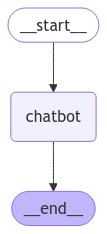

In [65]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [66]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hi! How can I help you today? 

Assistant: ## Business Plan: [Your Software Company Name]

**1. Executive Summary:**

[Write a concise and compelling overview of your software company. Include your company's mission, the problem you solve, your target market, your solution, and your competitive advantage. Highlight key financial projections and funding requirements.]

**2. Company Description:**

* **Company Name:** [Your Company Name]
* **Mission Statement:** [Clearly define your company's purpose and what it aims to achieve.]
* **Legal Structure:** [Sole proprietorship, partnership, LLC, corporation, etc.]
* **Location:** [Physical address and/or online presence]
* **Management Team:** [Briefly introduce key team members and their expertise.]

**3. Products and Services:**

* **Software Description:** [Detailed explanation of your software, its features, and functionalities.]
* **Value Proposition:** [What problems does your software solve for your customers? What benefits

In [80]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os

# Ensure the API key is set correctly
google_api_key = os.getenv("GOOGLE_API_KEY")  # Ensure this environment variable is set
tavily_api_key = os.getenv("TAVILY_API_KEY")
tool = TavilySearchResults(max_results=10, api_wrapper={"tavily_api_key": tavily_api_key})
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://saksheepatil05.medium.com/demystifying-langgraph-a-beginner-friendly-dive-into-langgraph-concepts-5ffe890ddac0',
  'content': 'Nodes (Tasks): Nodes are like the workstations on the assembly line. Each node performs a specific task on the product. In LangGraph, nodes are Python functions that take the current state, do some work, and return an updated state. Next, we define the nodes, each representing a task in our sandwich-making process.'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and mana

In [81]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import os

# Ensure the API key is set correctly
google_api_key = os.getenv("GOOGLE_API_KEY")  # Ensure this environment variable is set
tavily_api_key = os.getenv("TAVILY_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    api_key=google_api_key
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [82]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [83]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

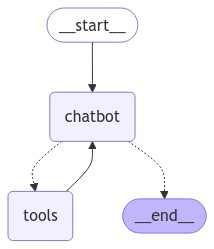

In [84]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [85]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
Assistant: 
Assistant: [{"url": "https://www.merriam-webster.com/dictionary/canvas", "content": "The meaning of CANVAS is a firm closely woven cloth usually of linen, hemp, or cotton used for clothing and formerly much used for tents and sails. How to use canvas in a sentence."}, {"url": "https://www.dictionary.com/browse/canvas", "content": "Canvas definition: a closely woven, heavy cloth 

In [74]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [87]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import ToolNode, tools_condition

import os

# Ensure the API key is set correctly
google_api_key = os.getenv("GOOGLE_API_KEY")  # Ensure this environment variable is set
tavily_api_key = os.getenv("TAVILY_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    api_key=google_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [91]:
graph = graph_builder.compile(checkpointer=memory)

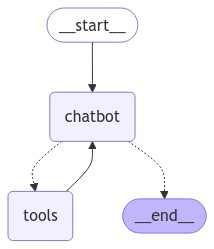

In [88]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [93]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================

Hi Will, it's nice to meet you! 👋  What can I do for you today?


In [94]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================

You're Will! 😊  Is there anything I can help you with today?


In [96]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='bca86746-7041-4480-bfee-6e1b717035d1'), AIMessage(content="I can't remember information from past conversations. If you'd like me to call you a specific name, please let me know! 😊 \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-d75cd5db-6d62-4dd7-838a-d4ba7ef2f36e-0', usage_metadata={'input_tokens': 78, 'output_tokens': 29, 'total_tokens': 107}), HumanMessage(content='Hi there! My name 

In [97]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

In [99]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import os

# Ensure the API key is set correctly
google_api_key = os.getenv("GOOGLE_API_KEY")  # Ensure this environment variable is set
tavily_api_key = os.getenv("TAVILY_API_KEY")
memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    api_key=google_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [100]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [101]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (334a0a08-0fb5-43fe-ba0c-ef84d1a9e9dc)
 Call ID: 334a0a08-0fb5-43fe-ba0c-ef84d1a9e9dc
  Args:
    query: LangGraph


In [102]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [103]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': '334a0a08-0fb5-43fe-ba0c-ef84d1a9e9dc',
  'type': 'tool_call'}]

In [104]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (334a0a08-0fb5-43fe-ba0c-ef84d1a9e9dc)
 Call ID: 334a0a08-0fb5-43fe-ba0c-ef84d1a9e9dc
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large langu

In [106]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    api_key=google_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


In [107]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (e5fb74f1-4958-4db3-82e7-e87ae3dc65e8)
 Call ID: e5fb74f1-4958-4db3-82e7-e87ae3dc65e8
  Args:
    query: LangGraph


In [108]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='028c64d8-2742-42d4-b5a2-aeb34f744895', tool_call_id='e5fb74f1-4958-4db3-82e7-e87ae3dc65e8'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='196241c9-0bb3-4438-a498-f03408723366')]


In [109]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [110]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef936a0-950e-668f-8003-1a4ebdd64ef7'}}

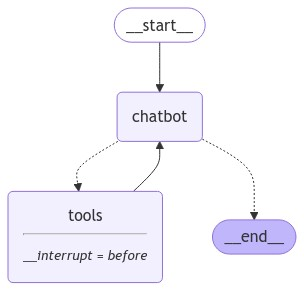

In [111]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [112]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='028c64d8-2742-42d4-b5a2-aeb34f744895', tool_call_id='e5fb74f1-4958-4db3-82e7-e87ae3dc65e8'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='196241c9-0bb3-4438-a498-f03408723366'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='c6a8c3c0-5e79-4369-ae12-d017ecad74a7')]
()


In [113]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (15e492b4-1fb5-4bc4-a660-4e081ce18bda)
 Call ID: 15e492b4-1fb5-4bc4-a660-4e081ce18bda
  Args:
    query: LangGraph


In [114]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-4893d0fc-51ed-4944-a834-bac58b97a732-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '15e492b4-1fb5-4bc4-a660-4e081ce18bda', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': '15e492b4-1fb5-4bc4-a660-4e081ce18bda', 'type': 'tool_call'}
Message ID run-4893d0fc-51ed-4944-a834-bac58b97a732-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '15e492b4-1fb5-4bc4-a660-4e081ce18bda',
  'type': 'tool_call'}]

In [115]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (15e492b4-1fb5-4bc4-a660-4e081ce18bda)
 Call ID: 15e492b4-1fb5-4bc4-a660-4e081ce18bda
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://medium.com/@kbdhunga/implementing-human-in-the-loop-with-langgraph-ccfde023385c", "content": "Implementing a Human-in-the-Loop (HIL) framework in LangGraph with the Streamlit app provides a robust mechanism for user engagement and decision-making. By incorporating breakpoints and"}]
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for compre

In [116]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================

You are learning about LangGraph.


In [117]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [118]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


In [119]:

from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    api_key=google_api_key
)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [120]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [121]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [122]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [124]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)


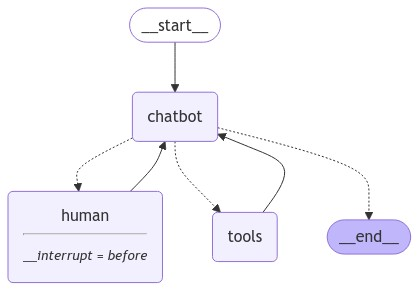

In [125]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [126]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'RequestAssistance', 'description': "Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.\n\nTo use this function, rela

In [127]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [128]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef936bc-74f5-6540-8002-5c3fc9950b7e'}}

In [129]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='bf86aac7-ae99-49d7-b59b-7c1f56ae8527'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "User requires expert guidance on building an AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-fbaba985-08e0-4fb2-9d3f-6c84bcae0c00-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'User re

In [150]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================

LangGraph is a framework for building applications with large language models (LLMs) where you define agents and their interactions as a graph. 

Here's a summary of what I found:

**Key Features:**

* **Graph-Based Representation:** LangGraph lets you visually design your application as a graph, making it easier to understand and manage complex interactions between different LLM agents.
* **Stateful Applications:** It supports statefulness, meaning your agents can remember past interactions and context, leading to more coherent and meaningful conversations or workflows.
* **Multi-Actor Systems:** LangGraph excels at building applications where multiple agents collaborate, communicate, and work towards a common goal. This is ideal for scenarios like multi-agent simulations or complex dialogue systems. 
* **Controllability:** You have fine-grained control over how information flows between agents and how t

In [135]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", api_key=google_api_key)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


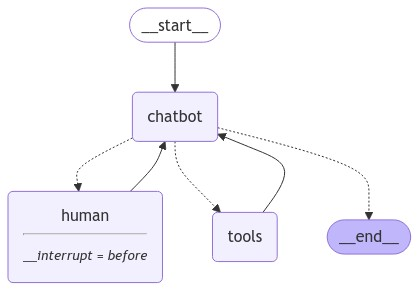

In [136]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [141]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'RequestAssistance', 'description': "Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.\n\nTo use this function, relay the user's 'request' so th

In [142]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  17 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  16 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  15 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  14 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  13 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  13 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  12 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  11 Next:  ('chatbot',)
----------------------------

In [143]:
print(to_replay.next)
print(to_replay.config)


('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef936c3-bf0e-61b2-8006-55e80aab3703'}}


In [144]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (648fc3e9-bcd0-4ec4-9a39-1a666a8084be)
 Call ID: 648fc3e9-bcd0-4ec4-9a39-1a666a8084be
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a library for building complex agentic systems with LLMs and other components. It supports diverse control flows, human-agent collaboration, streaming, and scalability with LangGraph Cloud."}]
{'name': 'tavily_search_results_json', 'description': 'A search en

In [149]:
config = {"configurable": {"thread_id": "1"}}
userinput = input("Enter your question: ")
events = graph.stream(
    {
        "messages": [
            ("user", userinput)
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'RequestAssistance', 'description': "Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.\n\nTo use this function, relay the user's 'request' so th